In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from nltk.stem import WordNetLemmatizer

**Read in target data**

In [2]:
data = pd.read_csv("data/training_variants.csv",index_col='ID')

In [3]:
data.head()

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [4]:
data.tail()

,Gene,Variation,Class
ID,,,
3316,RUNX1,D171N,4
3317,RUNX1,A122*,1
3318,RUNX1,Fusions,1
3319,RUNX1,R80C,4
3320,RUNX1,K83E,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gene       3321 non-null   object
 1   Variation  3321 non-null   object
 2   Class      3321 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 103.8+ KB


**Read in text data**

In [6]:
text = pd.read_csv('data/training_text.csv', sep = '\|\|', engine = 'python', names = ['ID','Text'], skiprows = 1, index_col = 'ID')

In [7]:
text.head()

,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
text.tail()

,Text
ID,
3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,The Runt-related transcription factor 1 gene (...
3319,The RUNX1/AML1 gene is the most frequent targe...
3320,The most frequent mutations associated with le...


In [9]:
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    3316 non-null   object
dtypes: object(1)
memory usage: 51.9+ KB


Combine data sets

In [10]:
merged = data.merge(text, how='left', on='ID')

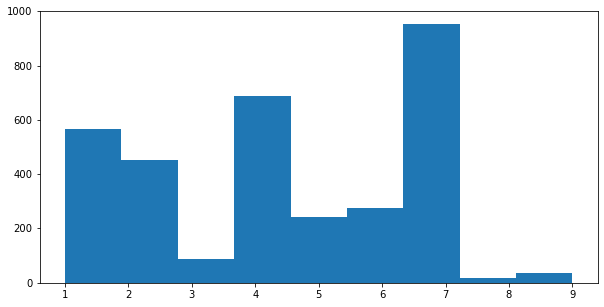

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(merged['Class'], bins=9);

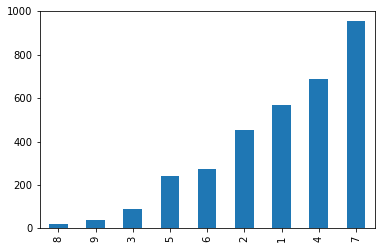

In [12]:
merged.Class.value_counts().sort_values().plot(kind = 'bar');
# df.letters.value_counts().sort_values().plot(kind = 'barh')

/home/shredder/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


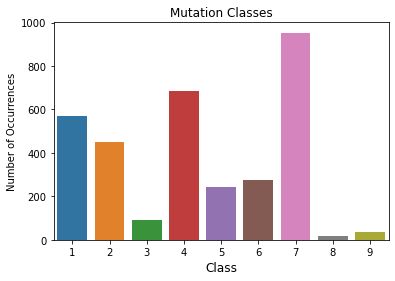

In [13]:
class_count  = merged['Class'].value_counts()
sns.barplot(class_count.index, class_count.values)
plt.title('Mutation Classes')
plt.ylabel('Number of Occurrences')
plt.xlabel('Class', fontsize=12);

In [14]:
merged[merged.isnull().any(axis=1)]

,Gene,Variation,Class,Text
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


In [15]:
# drop where text is missing
merged = merged.dropna(how='any', subset=['Text'])

In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gene       3316 non-null   object
 1   Variation  3316 non-null   object
 2   Class      3316 non-null   int64 
 3   Text       3316 non-null   object
dtypes: int64(1), object(3)
memory usage: 129.5+ KB


/home/shredder/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


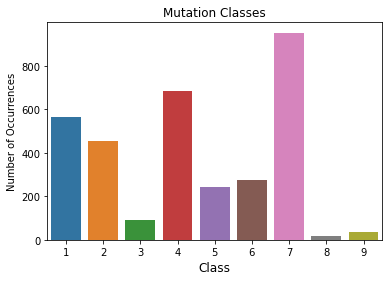

In [17]:
# redo plot after dropping missing text
class_count  = merged['Class'].value_counts()
sns.barplot(class_count.index, class_count.values)
plt.title('Mutation Classes')
plt.ylabel('Number of Occurrences')
plt.xlabel('Class', fontsize=12);

Try different models to classify - logistic reg, **random forest**, **naive bayes**

Combine predictors - df['vectorized'] = df['text'] + ' ' + df['gene']+ df['variant']

In [18]:
text_list = merged.Text.tolist()

In [19]:
len(text_list)

3316

In [20]:
y = merged['Class']

In [21]:
type(y)

pandas.core.series.Series

In [22]:
# y[:5]

Functions

In [23]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [43]:
def confusion_matrix_plot():
    df_cm = pd.DataFrame(cm, range(9), range(9))
    plt.figure(figsize = (12,10))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g', xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

In [25]:
# custom stop words
stops = ['figure', 'fig', 'al', 'et', 
         '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
         '2010', '2011', '2012', '2013', '2014', '2017',
         '1a', '1b', '1c', '1d', '1e', '1f',
         '2a', '2b', '2c', '2d', '2e', '2f',
         '3a', '3b', '3c', '3d', '3e', '3f',
         '4a', '4b', '4c', '4d', '4e', '4f',
         '5a', '5b', '5c', '5d',
         '6a', '6b', '6c', '6d',
         '7a', '7b', '7c',
         'wang', 'zhang']

**Vectorize and Train-Test Split**

In [ ]:
# initial vectorize
# vectorizer = CountVectorizer()

In [ ]:
# X = vectorizer.fit_transform(text_list)

In [ ]:
# X.shape

In [ ]:
# vectorize with stopwords
vectorizer = CountVectorizer(stop_words='english')

In [ ]:
X = vectorizer.fit_transform(text_list)

In [ ]:
X.shape

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=88)

**Model 1 - Naive Bayes**

In [ ]:
model = MultinomialNB()

In [38]:
model.fit(X_train, y_train)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
print(model.predict(X_test[:5]))

In [ ]:
print(model.predict(X_test[-5:]))

In [ ]:
model.predict_proba(X_train[0])

In [ ]:
model.predict_proba(X_test[900])


In [ ]:
model.score(X_test, y_test)

Look at model metrics from previous project - accuracy, precision, recall, confusion matrix

Again with tf-idf vectorizer

**More robust vectorizations**

In [22]:
vectorizer = CountVectorizer(min_df=.2, max_df=.8)

In [23]:
X = vectorizer.fit_transform(text_list) 

In [24]:
X.shape

(3316, 1921)

In [25]:
len(vectorizer.vocabulary_)

1921

In [27]:
# vectorizer.vocabulary_

In [28]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

000 0
0001 1
001 2
01 3
05 4
1000 5
104 6
105 7
106 8
107 9
120 10
150 11
1994 12
1996 13
1997 14
1998 15
1999 16
1a 17
1b 18
1c 19
1d 20
1e 21
200 22
2000 23
2001 24
2002 25
2003 26
2004 27
2005 28
2006 29
2007 30
2008 31
2009 32
2010 33
2011 34
2012 35
2013 36
250 37
27 38
28 39
293t 40
2a 41
2b 42
2c 43
2d 44
300 45
31 46
32 47
33 48
34 49
35 50
36 51
37 52
38 53
39 54
3a 55
3b 56
3c 57
3d 58
400 59
41 60
42 61
43 62
44 63
45 64
46 65
47 66
48 67
49 68
4a 69
4b 70
4c 71
4d 72
4e 73
500 74
51 75
52 76
53 77
54 78
55 79
56 80
57 81
58 82
59 83
5a 84
5b 85
5c 86
60 87
600 88
61 89
62 90
63 91
64 92
65 93
66 94
67 95
68 96
69 97
6a 98
6b 99
6c 100
70 101
71 102
72 103
73 104
74 105
75 106
76 107
77 108
78 109
79 110
80 111
81 112
82 113
83 114
84 115
85 116
86 117
87 118
88 119
89 120
90 121
91 122
92 123
93 124
94 125
95 126
96 127
97 128
98 129
99 130
aa 131
aberrant 132
aberrations 133
ability 134
able 135
abnormal 136
abnormalities 137
abolished 138
about 139
above 140
abrogated 141

targeting 1745
targets 1746
technologies 1747
technology 1748
temperature 1749
template 1750
ten 1751
term 1752
terminal 1753
terminus 1754
terms 1755
test 1756
tested 1757
testing 1758
tests 1759
text 1760
them 1761
therapeutic 1762
therapies 1763
therapy 1764
thereby 1765
third 1766
though 1767
thought 1768
threonine 1769
threshold 1770
throughout 1771
time 1772
times 1773
tissue 1774
tissues 1775
together 1776
tolerated 1777
tool 1778
top 1779
toward 1780
towards 1781
tp53 1782
transactivation 1783
transcript 1784
transcription 1785
transcriptional 1786
transcripts 1787
transduced 1788
transduction 1789
transfected 1790
transfection 1791
transfections 1792
transferred 1793
transformation 1794
transformed 1795
transforming 1796
transient 1797
transiently 1798
transition 1799
translation 1800
translational 1801
translocation 1802
transmembrane 1803
treated 1804
treatment 1805
treatments 1806
trial 1807
trials 1808
triplicate 1809
tris 1810
triton 1811
true 1812
truncated 1813
truncati

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [39]:
model = MultinomialNB()

In [40]:
model.fit(X_train, y_train)

MultinomialNB()

In [41]:
print(model.predict(X_test[:5]))

[6 2 8 5 7]


In [42]:
model.score(X_test, y_test)

0.4844221105527638

**Vectorized with min = .1 and max = .9**

In [23]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9)

In [24]:
X = vectorizer.fit_transform(text_list) 

In [25]:
X.shape

(3316, 3579)

In [25]:
len(vectorizer.vocabulary_)

3579

In [26]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
112 30
113 31
115 32
117 33
119 34
120 35
121 36
123 37
124 38
125 39
13 40
130 41
132 42
138 43
140 44
150 45
16 46
160 47
1640 48
17 49
170 50
18 51
180 52
19 53
1991 54
1992 55
1993 56
1994 57
1995 58
1996 59
1997 60
1998 61
1999 62
1a 63
1b 64
1c 65
1d 66
1e 67
1f 68
200 69
2000 70
2001 71
2002 72
2003 73
2004 74
2005 75
2006 76
2007 77
2008 78
2009 79
2010 80
2011 81
2012 82
2013 83
2014 84
2017 85
21 86
22 87
23 88
24 89
25 90
250 91
26 92
27 93
28 94
29 95
293 96
293t 97
2a 98
2b 99
2c 100
2d 101
2e 102
2f 103
30 104
300 105
31 106
32 107
32p 108
33 109
34 110
35 111
350 112
36 113
37 114
38 115
39 116
3a 117
3b 118
3c 119
3d 120
3e 121
3f 122
3t3 123
40 124
400 125
41 126
42 127
43 128
44 129
45 130
46 131
47 132
48 133
49 134
4a 135
4b 136
4c 137
4d 138
4e 139
4f 140
50 141
500 142
51 143

hek293t 1570
hela 1571
helical 1572
helices 1573
helix 1574
help 1575
helpful 1576
hematologic 1577
hematopoietic 1578
hematoxylin 1579
hence 1580
hepatocellular 1581
hepes 1582
her 1583
her2 1584
hercules 1585
here 1586
hereditary 1587
herein 1588
heterodimer 1589
heterodimerization 1590
heterogeneity 1591
heterogeneous 1592
heterologous 1593
heterozygosity 1594
heterozygous 1595
higher 1596
highest 1597
highlight 1598
highlighted 1599
highlighting 1600
highlights 1601
highly 1602
his 1603
histidine 1604
histologic 1605
histological 1606
histologically 1607
histology 1608
histone 1609
history 1610
homo 1611
homolog 1612
homologous 1613
homologs 1614
homology 1615
homozygous 1616
hormone 1617
horseradish 1618
hospital 1619
hot 1620
hotspot 1621
hotspots 1622
hour 1623
hours 1624
how 1625
hr 1626
hras 1627
hrp 1628
http 1629
humans 1630
hundred 1631
hybrid 1632
hybridization 1633
hydrogen 1634
hydrophobic 1635
hypothesis 1636
hypothesize 1637
hypothesized 1638
iarc 1639
ic50 1640
ice 16

technology 3270
temperature 3271
template 3272
ten 3273
tend 3274
tended 3275
term 3276
termed 3277
terminal 3278
termination 3279
terminator 3280
terminus 3281
terms 3282
test 3283
tested 3284
testing 3285
tests 3286
text 3287
them 3288
then 3289
therapeutic 3290
therapeutics 3291
therapies 3292
therapy 3293
there 3294
thereby 3295
therefore 3296
thermo 3297
they 3298
third 3299
thirty 3300
those 3301
though 3302
thought 3303
thr 3304
threonine 3305
threshold 3306
through 3307
throughout 3308
throughput 3309
thus 3310
thyroid 3311
tightly 3312
time 3313
times 3314
tissue 3315
tissues 3316
tk 3317
tki 3318
tkis 3319
together 3320
tolerated 3321
too 3322
took 3323
tool 3324
tools 3325
top 3326
total 3327
toward 3328
towards 3329
toxic 3330
toxicity 3331
tp53 3332
tract 3333
trans 3334
transactivation 3335
transcribed 3336
transcript 3337
transcriptase 3338
transcription 3339
transcriptional 3340
transcripts 3341
transduced 3342
transduction 3343
transfectants 3344
transfected 3345
trans

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [28]:
model = MultinomialNB()

In [29]:
model.fit(X_train, y_train)

MultinomialNB()

In [30]:
model.score(X_test, y_test)

0.5045226130653266

In [31]:
y_pred = model.predict(X_test)

In [32]:
print(accuracy_score(y_test, y_pred))

0.5045226130653266


Get feature importances

In [41]:
class_labels = model.classes_
class_labels

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
print_top10(vectorizer, model, class_labels)

1: table brca1 genes tumor variants figure fig al et p53
2: tumors kit tumor egfr fig kinase figure al et patients
3: mutants functional assay mtor alk figure et al variants brca1
4: proteins mutants p53 variants figure fig brca1 al et pten
5: et al assay variant neutral assays functional fig variants brca1
6: interaction variant family figure brca2 kinase deleterious fig variants brca1
7: kit activation tumor al et figure kinase fig egfr patients
8: tumor histone tumors samples fig genes akt figure et al
9: samples supplementary exon al et rna fig genes figure splicing


In [43]:
model.feature_log_prob_
# model.coef_ (this is the same thing)

array([[ -8.59136478,  -7.6044859 ,  -8.93563432, ...,  -8.22214746,
         -8.02025725,  -9.64257483],
       [ -9.60750367,  -7.46743751,  -8.59379083, ...,  -8.17020676,
         -7.8157442 ,  -9.59594285],
       [-10.22900717,  -7.94081081,  -8.99686349, ...,  -7.81820849,
         -8.51135567, -10.09547578],
       ...,
       [ -9.1917289 ,  -7.43849822,  -8.5855931 , ...,  -8.07238581,
         -7.44324206,  -9.97039826],
       [-10.13895485,  -7.17712413,  -9.1581256 , ...,  -7.6540482 ,
         -8.34719538,  -9.1581256 ],
       [ -9.17933119,  -7.24942138,  -9.58479629, ...,  -8.43211678,
         -8.8116064 ,  -9.07397067]])

Update class names

In [47]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 91,   7,   1,  21,  27,   3,   7,   5,   2],
       [ 13,  77,   1,   2,   3,   2,  44,   4,   1],
       [  3,   1,  15,   3,   0,   0,   8,   0,   0],
       [ 71,   8,   6,  89,  13,   2,  13,   1,   4],
       [  7,   6,   1,   6,  33,   2,   9,   4,   0],
       [ 11,  14,   1,   1,  10,  39,   8,   0,   0],
       [ 21,  78,   8,   7,   3,   0, 150,   9,   0],
       [  3,   1,   0,   0,   0,   0,   1,   0,   0],
       [  3,   0,   0,   0,   0,   0,   0,   3,   8]])

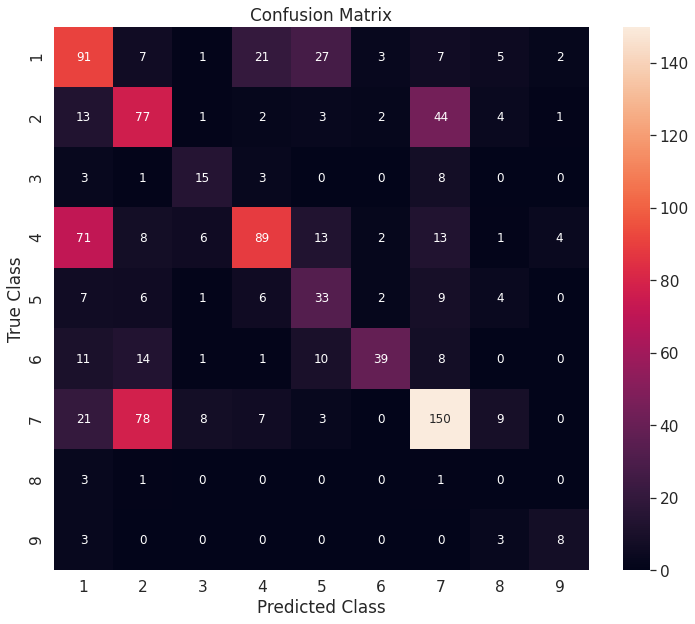

In [56]:
confusion_matrix()
# plt.savefit('img/conf_matrix.png')

**Vectorized with Binary**

In [57]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, binary=True)

In [58]:
X = vectorizer.fit_transform(text_list) 

In [59]:
X.shape

(3316, 3579)

In [60]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [61]:
model = MultinomialNB()

In [62]:
model.fit(X_train, y_train)

MultinomialNB()

In [64]:
model.score(X_test, y_test)

0.5145728643216081

In [65]:
model.feature_count_

array([[ 53., 204.,  82., ..., 127., 163.,  47.],
       [ 35., 156.,  67., ...,  88., 111.,  44.],
       [  5.,  30.,   9., ...,  25.,  21.,   5.],
       ...,
       [113., 412., 172., ..., 251., 379.,  75.],
       [  2.,   9.,   4., ...,   8.,   8.,   2.],
       [  6.,  16.,   5., ...,   7.,  10.,   8.]])

**Vectorized with min = .1 and max = .9 and including manual stop words list**

In [23]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)

In [24]:
X = vectorizer.fit_transform(text_list)

In [25]:
X.shape

(3316, 3513)

In [26]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
112 30
113 31
115 32
117 33
119 34
120 35
121 36
123 37
124 38
125 39
13 40
130 41
132 42
138 43
140 44
150 45
16 46
160 47
1640 48
17 49
170 50
18 51
180 52
19 53
200 54
21 55
22 56
23 57
24 58
25 59
250 60
26 61
27 62
28 63
29 64
293 65
293t 66
30 67
300 68
31 69
32 70
32p 71
33 72
34 73
35 74
350 75
36 76
37 77
38 78
39 79
3t3 80
40 81
400 82
41 83
42 84
43 85
44 86
45 87
46 88
47 89
48 90
49 91
50 92
500 93
51 94
52 95
53 96
54 97
55 98
56 99
57 100
58 101
59 102
60 103
600 104
61 105
62 106
63 107
64 108
65 109
66 110
67 111
68 112
69 113
70 114
71 115
72 116
73 117
74 118
75 119
76 120
77 121
78 122
79 123
80 124
800 125
81 126
82 127
83 128
84 129
85 130
86 131
87 132
88 133
89 134
90 135
91 136
92 137
93 138
94 139
95 140
96 141
97 142
98 143
99 144
aa 145
aacr 146
aacrjournals 147
abbrevi

genotypes 1438
genotyping 1439
germ 1440
germany 1441
germline 1442
gfp 1443
gibco 1444
gift 1445
give 1446
given 1447
gives 1448
giving 1449
glioblastoma 1450
glioma 1451
global 1452
glu 1453
glucose 1454
glutamine 1455
glutathione 1456
glycerol 1457
glycine 1458
go 1459
goal 1460
goat 1461
good 1462
gov 1463
grade 1464
gradient 1465
graph 1466
graphpad 1467
gray 1468
great 1469
greater 1470
greatest 1471
greatly 1472
green 1473
grew 1474
groove 1475
group 1476
groups 1477
grow 1478
growing 1479
grown 1480
growth 1481
gst 1482
gtp 1483
gtpase 1484
guide 1485
guidelines 1486
ha 1487
hairpin 1488
half 1489
hallmark 1490
hand 1491
harbor 1492
harbored 1493
harboring 1494
harbors 1495
harvested 1496
having 1497
hcl 1498
he 1499
head 1500
health 1501
healthcare 1502
healthy 1503
heat 1504
hek 1505
hek293t 1506
hela 1507
helical 1508
helices 1509
helix 1510
help 1511
helpful 1512
hematologic 1513
hematopoietic 1514
hematoxylin 1515
hence 1516
hepatocellular 1517
hepes 1518
her 1519
her2 152

situation 2979
six 2980
size 2981
sizes 2982
skin 2983
slide 2984
slides 2985
slight 2986
slightly 2987
sloan 2988
slow 2989
small 2990
smaller 2991
snp 2992
snps 2993
so 2994
sodium 2995
soft 2996
software 2997
solely 2998
solid 2999
soluble 3000
solution 3001
solved 3002
solvent 3003
somatic 3004
somatically 3005
some 3006
sometimes 3007
somewhat 3008
sorting 3009
sought 3010
source 3011
sources 3012
space 3013
spanning 3014
species 3015
specifically 3016
specificity 3017
specified 3018
specimen 3019
specimens 3020
spectra 3021
spectrometry 3022
spectrum 3023
speculate 3024
spindle 3025
splice 3026
spliced 3027
splicing 3028
split 3029
spontaneous 3030
sporadic 3031
spot 3032
spots 3033
spread 3034
squamous 3035
square 3036
src 3037
st 3038
stability 3039
stabilization 3040
stabilize 3041
stabilized 3042
stabilizes 3043
stabilizing 3044
stable 3045
stably 3046
stage 3047
stages 3048
stain 3049
stained 3050
staining 3051
standard 3052
standardized 3053
start 3054
started 3055
starting

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [28]:
model = MultinomialNB()

In [29]:
model.fit(X_train, y_train)

MultinomialNB()

In [30]:
model.score(X_test, y_test)

0.5095477386934674

In [31]:
y_pred = model.predict(X_test)

In [44]:
class_labels = model.classes_

In [45]:
print_top10(vectorizer, model, class_labels)

1: proteins function tumors patients table brca1 genes tumor variants p53
2: table activation exon braf tumors kit tumor egfr kinase patients
3: patients kinase variant mutants functional assay mtor alk variants brca1
4: ras functional tumor function proteins mutants p53 variants brca1 pten
5: brct table deleterious variant assay neutral assays functional variants brca1
6: tumor resistance interaction variant family brca2 kinase deleterious variants brca1
7: mutants exon tumors ras kit activation tumor kinase egfr patients
8: methylation supplementary table kinase tumor histone tumors samples genes akt
9: splice aberrant table patients samples supplementary exon rna genes splicing


In [42]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 93,   7,   1,  18,  27,   4,   7,   5,   2],
       [ 12,  77,   1,   3,   3,   2,  44,   4,   1],
       [  3,   1,  15,   3,   0,   0,   8,   0,   0],
       [ 71,   8,   6,  89,  13,   2,  13,   0,   5],
       [  5,   6,   1,   5,  33,   5,   9,   3,   1],
       [  9,  13,   1,   1,  10,  41,   9,   0,   0],
       [ 21,  81,   8,   5,   3,   0, 151,   7,   0],
       [  3,   1,   0,   0,   0,   0,   1,   0,   0],
       [  3,   0,   0,   0,   0,   0,   0,   3,   8]])

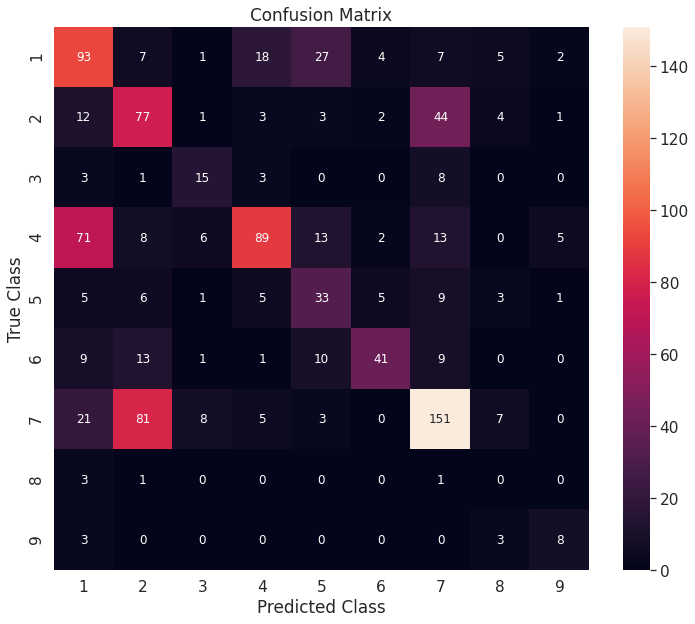

In [37]:
confusion_matrix()

**Reorder vectorization**

In [26]:
# train test split first
X_train, X_test, y_train, y_test = train_test_split(text_list, y, test_size=.3, random_state=88, stratify=y)

In [27]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)

In [28]:
X_train_vec = vectorizer.fit_transform(X_train)

In [29]:
X_train_vec.shape

(2321, 3499)

In [30]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
112 30
113 31
115 32
117 33
119 34
120 35
121 36
123 37
124 38
125 39
13 40
130 41
132 42
138 43
140 44
150 45
16 46
160 47
1640 48
17 49
170 50
18 51
180 52
19 53
200 54
21 55
22 56
23 57
24 58
25 59
250 60
26 61
27 62
28 63
29 64
293 65
293t 66
30 67
300 68
31 69
32 70
32p 71
33 72
34 73
35 74
350 75
36 76
37 77
38 78
39 79
3t3 80
40 81
400 82
41 83
42 84
43 85
44 86
45 87
46 88
47 89
48 90
49 91
50 92
500 93
51 94
52 95
53 96
54 97
55 98
56 99
57 100
58 101
59 102
60 103
600 104
61 105
62 106
63 107
64 108
65 109
66 110
67 111
68 112
69 113
70 114
71 115
72 116
73 117
74 118
75 119
76 120
77 121
78 122
79 123
80 124
800 125
81 126
82 127
83 128
84 129
85 130
86 131
87 132
88 133
89 134
90 135
91 136
92 137
93 138
94 139
95 140
96 141
97 142
98 143
99 144
aa 145
aacr 146
aacrjournals 147
abbrevi

glu 1449
glucose 1450
glutamine 1451
glutathione 1452
glycerol 1453
glycine 1454
go 1455
goal 1456
goat 1457
good 1458
gov 1459
grade 1460
gradient 1461
graph 1462
graphpad 1463
gray 1464
great 1465
greater 1466
greatest 1467
greatly 1468
green 1469
grew 1470
groove 1471
group 1472
groups 1473
grow 1474
growing 1475
grown 1476
growth 1477
gst 1478
gtp 1479
gtpase 1480
guide 1481
guidelines 1482
ha 1483
hairpin 1484
half 1485
hallmark 1486
hand 1487
harbor 1488
harbored 1489
harboring 1490
harbors 1491
harvested 1492
having 1493
hcl 1494
he 1495
head 1496
health 1497
healthcare 1498
healthy 1499
heat 1500
hek 1501
hek293t 1502
hela 1503
helical 1504
helices 1505
helix 1506
help 1507
helpful 1508
hematologic 1509
hematopoietic 1510
hematoxylin 1511
hence 1512
hepatocellular 1513
hepes 1514
her 1515
her2 1516
hercules 1517
here 1518
hereditary 1519
herein 1520
heterodimer 1521
heterodimerization 1522
heterogeneity 1523
heterogeneous 1524
heterologous 1525
heterozygosity 1526
heterozygous 

respective 2776
respectively 2777
respond 2778
responded 2779
response 2780
responses 2781
responsible 2782
responsive 2783
responsiveness 2784
rest 2785
restore 2786
restored 2787
restricted 2788
restriction 2789
result 2790
resultant 2791
resulted 2792
resulting 2793
resuspended 2794
retain 2795
retained 2796
retains 2797
retention 2798
retroviral 2799
retrovirus 2800
reveal 2801
revealed 2802
revealing 2803
reveals 2804
reverse 2805
reversible 2806
review 2807
reviewed 2808
rich 2809
right 2810
ring 2811
ripa 2812
rise 2813
risk 2814
risks 2815
rna 2816
rnas 2817
rneasy 2818
robust 2819
roche 2820
role 2821
roles 2822
room 2823
roughly 2824
routine 2825
routinely 2826
rpmi 2827
rt 2828
rtk 2829
rtks 2830
rule 2831
run 2832
s1 2833
s1a 2834
s1b 2835
s2 2836
s2a 2837
s2b 2838
s2c 2839
s3 2840
s3a 2841
s3b 2842
s4 2843
s5 2844
s6 2845
s7 2846
saline 2847
salt 2848
same 2849
sample 2850
samples 2851
san 2852
sanger 2853
santa 2854
sarcoma 2855
sc 2856
scale 2857
scan 2858
scanning 2859


In [31]:
X_test_vec = vectorizer.transform(X_test)

In [32]:
X_test_vec.shape

(995, 3499)

In [64]:
vectorizer.get_feature_names()[3000]

'sought'

**Model - Naive Bayes**

In [33]:
nb = MultinomialNB()

In [34]:
nb.fit(X_train_vec, y_train)

MultinomialNB()

In [35]:
nb.score(X_test_vec, y_test)

0.5145728643216081

In [37]:
y_pred = nb.predict(X_test_vec)
class_labels = nb.classes_

In [38]:
print_top10(vectorizer, nb, class_labels)

1: function brca1 patients tumors proteins table genes tumor variants p53
2: ras activation exon tumors braf kit tumor kinase egfr patients
3: pten flt3 functional patients mutants assay mtor alk variants brca1
4: table functional tumor function proteins mutants brca1 p53 variants pten
5: deleterious neutral table brct variant assay assays functional brca1 variants
6: sequence family kinase tumor variant interaction brca2 deleterious variants brca1
7: mutants alk kit tumors ras activation tumor kinase egfr patients
8: table transcription tumor methylation kinase tumors samples genes histone akt
9: levels splice supplementary exon wt patients samples rna genes splicing


In [41]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 81,  14,   0,  31,  27,   2,   8,   3,   4],
       [  3,  74,   1,   5,   4,   1,  41,   6,   0],
       [  4,   2,  10,   2,   1,   0,   8,   0,   0],
       [ 56,   7,   5,  94,  11,   5,  24,   1,   3],
       [  2,   8,   1,   6,  37,   6,  10,   0,   2],
       [ 11,   7,   0,   4,   6,  38,  16,   0,   0],
       [ 13,  78,  11,  11,   0,   0, 169,   4,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   4],
       [  1,   0,   0,   0,   0,   0,   0,   1,   9]])

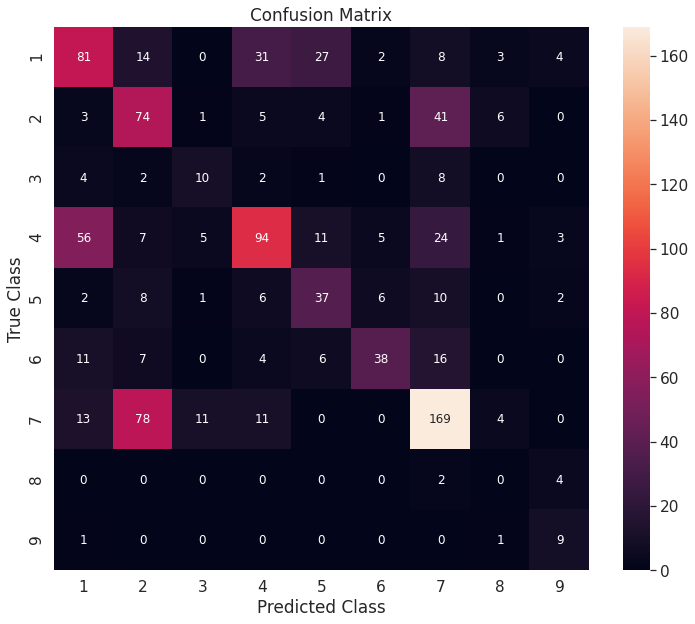

In [44]:
confusion_matrix_plot()

**Model - Random Forest**

In [45]:
rf = RandomForestClassifier()

In [46]:
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [47]:
rf.score(X_test_vec, y_test)

0.650251256281407

In [48]:
y_pred = model.predict(X_test_vec)
class_labels = model.classes_

In [58]:
rf.feature_importances_

array([2.39283131e-04, 3.87215210e-04, 2.73239652e-04, ...,
       3.34193494e-04, 3.48575846e-04, 2.07250269e-05])

In [69]:
cols = np.array(vectorizer.get_feature_names())

In [70]:
sorted_idx = rf.feature_importances_.argsort()[-10:]

In [71]:
cols[sorted_idx]

array(['inhibition', 'nonsense', 'functional', 'suppressor', 'function',
       'tyrosine', 'activation', 'constitutive', 'kinase', 'activating'],
      dtype='<U20')

In [72]:
rf.feature_importances_[sorted_idx]

array([0.00266346, 0.00337729, 0.00348436, 0.00357088, 0.00377476,
       0.00377997, 0.00419916, 0.00603565, 0.00646061, 0.00701682])

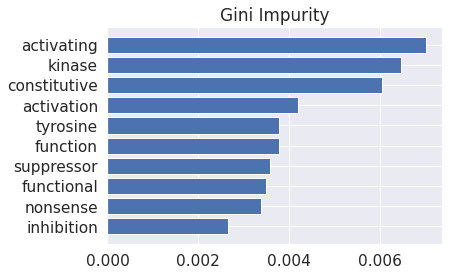

In [78]:
plt.barh(cols[sorted_idx], rf.feature_importances_[sorted_idx])
plt.title('Gini Impurity');

In [73]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 81,  14,   0,  31,  27,   2,   8,   3,   4],
       [  3,  74,   1,   5,   4,   1,  41,   6,   0],
       [  4,   2,  10,   2,   1,   0,   8,   0,   0],
       [ 56,   7,   5,  94,  11,   5,  24,   1,   3],
       [  2,   8,   1,   6,  37,   6,  10,   0,   2],
       [ 11,   7,   0,   4,   6,  38,  16,   0,   0],
       [ 13,  78,  11,  11,   0,   0, 169,   4,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   4],
       [  1,   0,   0,   0,   0,   0,   0,   1,   9]])

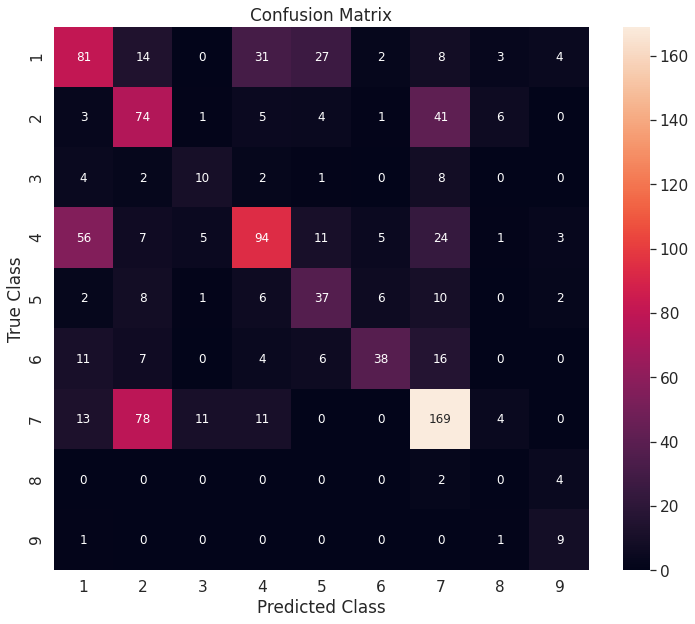

In [74]:
confusion_matrix_plot()